**TRAINING THE BASELINE MODEL**: The task is to classify each image into 6 classes, 1 being "no hemorrhage" and the other 5 the types of hemorrhage, using windowing images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/Shareddrives/Projeto DACO/scripts code

/content/drive/Shareddrives/Projeto DACO/scripts code


In [ ]:
pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install import-ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.4 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torchvision.ops.focal_loss import sigmoid_focal_loss
import albumentations as A
from albumentations.pytorch import ToTensorV2
from time import time
from tqdm import tqdm
from torchinfo import summary
import datetime
import importlib
import os
import argparse
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torchvision.models as models

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.utils import class_weight

# Dataloader
import import_ipynb
from dataloader import small_dataset
from sklearn import preprocessing


from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

importing Jupyter notebook from dataloader.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Detection's Label Map
Class 0 -  ['hemorrhage']
Class 1 -  ['no hemorrhage']

Classification's Label Map
Class 0 -  [' epidural']
Class 1 -  [' intraparenchymal']
Class 2 -  [' intraventricular']
Class 3 -  [' subarachnoid']
Class 4 -  [' subdural']
Class 5 -  ['no hemorrhage']
[10.925       0.99036827  1.52663755  0.90805195  0.46675567]
Using cuda


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=6):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
###################### TRAINING MODE #####################

dataset_fold = 'windowing' 
model_selected = 'VGG'

print(f'Training Mode using {dataset_fold} images')


################## PARAMETERS ##################

img_size = 224
BATCH_SIZE = 16
LEARNING_RATE = 0.000005 
NUM_WORKERS = 2
EPOCHS = 95

Training Mode using windowing images


In [ ]:
def epoch_iterations (dataloader, model, loss_fc, device, name, opt=None, is_training=True):
  if (is_training):
      assert opt is not None, "When training, please provide an optimizer."
      model.train() 
  else:
    model.eval()
  
  model.to(device) 
  
  tic = time()
  total_time = 0
  
  true_label = []
  final_pred = []
  avg_loss = 0
  
  
  with torch.set_grad_enabled(is_training):
    for img, notlabel, label in tqdm(dataloader):
        img = img.to(device)
        
        for i in label:
          true_label.append(int(i.numpy()))
        
        label = label.type(torch.LongTensor)
        label = label.to(device)

        label_pred = model(img)

        loss = loss_fc(label_pred, label)

        if (is_training):
          opt.zero_grad()
          loss.backward()
          opt.step()

        avg_loss += float(loss.item()) / len(dataloader)

        y_pred = torch.softmax(label_pred, dim=1).argmax(dim=1)
        
        for j in y_pred.cpu():
          final_pred.append(int(j.detach().numpy()))


  toc = time()
  total_time += toc-tic

  print(f'{name} - Time: {toc-tic:.1f}s - Loss: {avg_loss}')

  return avg_loss, true_label, final_pred

  

In [ ]:
import seaborn as sns

def evaluation_metrics (true_label, final_pred):
  # Confusion matrix
    confusion_matrix = metrics.confusion_matrix(true_label, final_pred, labels = [0,1,2,3,4,5])
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4,5])
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show(block=False)


In [ ]:
def loss_plot (epochs, train_loss, val_loss):
  fig = plt.figure(figsize=(10,5))
  plt.title('Loss')
  plt.plot(epochs, train_loss, label='train')
  plt.plot(epochs, val_loss, label='val')
  plt.legend(loc='best')

  plt.tight_layout()
  plt.legend(loc='best')
  plt.show()


Loading dataset

Detection's Label Map
Class 0 -  ['hemorrhage']
Class 1 -  ['no hemorrhage']

Classification's Label Map
Class 0 -  [' epidural']
Class 1 -  [' intraparenchymal']
Class 2 -  [' intraventricular']
Class 3 -  [' subarachnoid']
Class 4 -  [' subdural']
Class 5 -  ['no hemorrhage']

Loaded 


Training
* Epoch 1 / 95


100%|██████████| 372/372 [55:43<00:00,  8.99s/it]


TRAIN - Time: 3343.4s - Loss: 1.7698351606245948


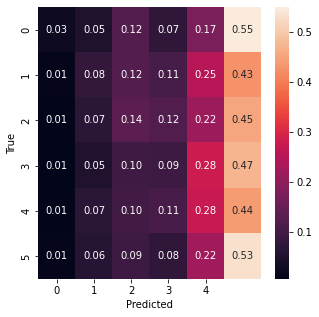

100%|██████████| 80/80 [11:53<00:00,  8.91s/it]


VALIDATION - Time: 713.1s - Loss: 1.7877946496009827


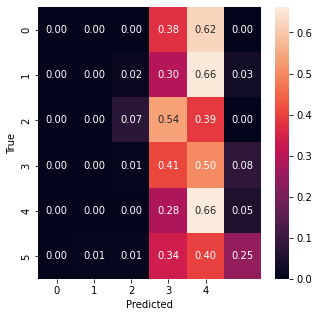

* Epoch 2 / 95


100%|██████████| 372/372 [02:00<00:00,  3.08it/s]


TRAIN - Time: 120.7s - Loss: 1.7487067567404886


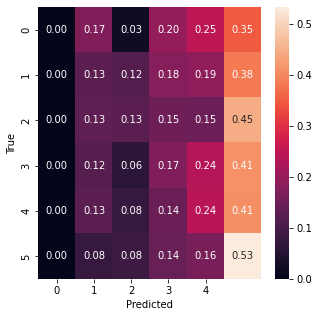

100%|██████████| 80/80 [00:13<00:00,  6.14it/s]


VALIDATION - Time: 13.0s - Loss: 1.850361004471779


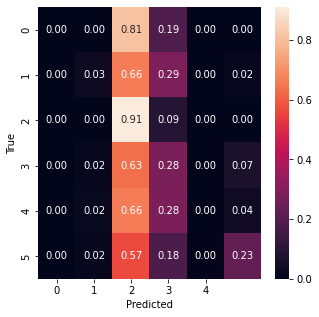

* Epoch 3 / 95


100%|██████████| 372/372 [01:58<00:00,  3.14it/s]


TRAIN - Time: 118.6s - Loss: 1.7359116449150982


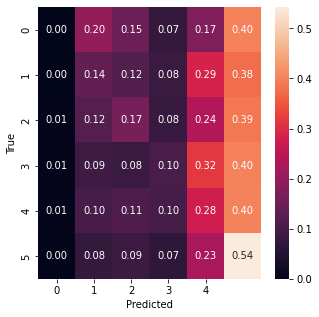

100%|██████████| 80/80 [00:12<00:00,  6.18it/s]


VALIDATION - Time: 13.0s - Loss: 1.7358677044510833


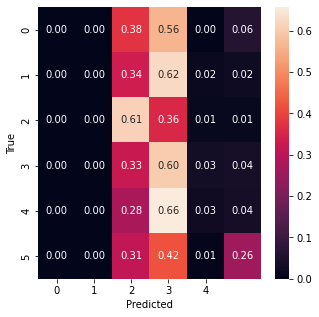

* Epoch 4 / 95


100%|██████████| 372/372 [02:00<00:00,  3.09it/s]


TRAIN - Time: 120.2s - Loss: 1.7213710748380227


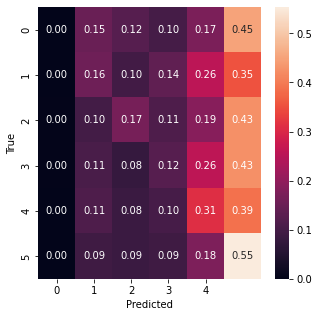

100%|██████████| 80/80 [00:13<00:00,  6.07it/s]


VALIDATION - Time: 13.2s - Loss: 1.7046109780669212


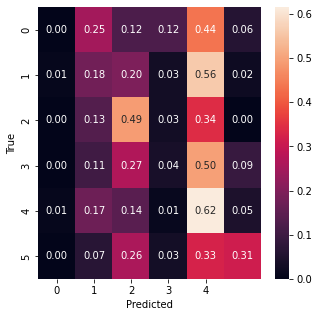

* Epoch 5 / 95


100%|██████████| 372/372 [02:00<00:00,  3.09it/s]


TRAIN - Time: 120.6s - Loss: 1.7256402751450912


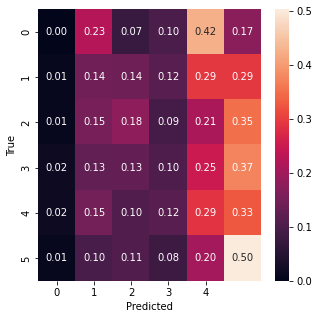

100%|██████████| 80/80 [00:13<00:00,  6.12it/s]


VALIDATION - Time: 13.1s - Loss: 1.7898287117481233


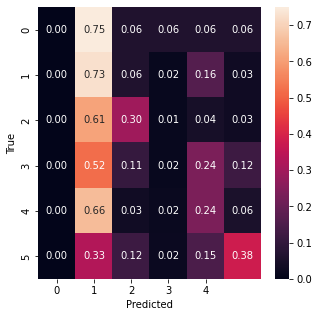

* Epoch 6 / 95


100%|██████████| 372/372 [01:59<00:00,  3.12it/s]


TRAIN - Time: 119.4s - Loss: 1.7378081025615812


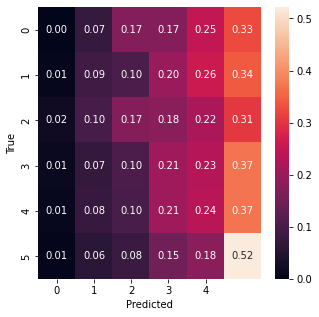

100%|██████████| 80/80 [00:13<00:00,  5.96it/s]


VALIDATION - Time: 13.4s - Loss: 1.737800019234419


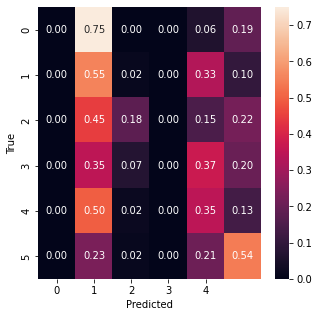

* Epoch 7 / 95


100%|██████████| 372/372 [02:00<00:00,  3.09it/s]


TRAIN - Time: 120.6s - Loss: 1.7163989242687039


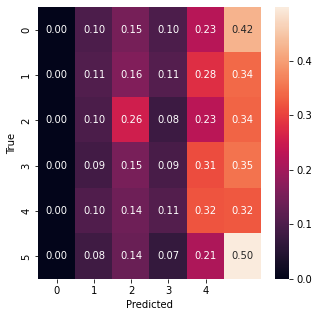

100%|██████████| 80/80 [00:13<00:00,  5.86it/s]


VALIDATION - Time: 13.7s - Loss: 1.7324998632073396


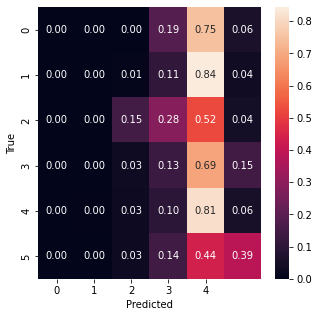

* Epoch 8 / 95


100%|██████████| 372/372 [02:00<00:00,  3.08it/s]


TRAIN - Time: 120.8s - Loss: 1.7108211578220451


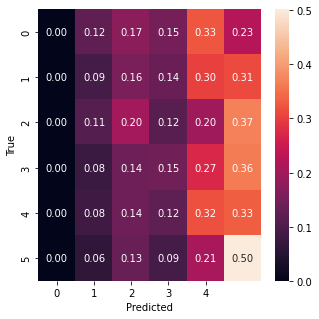

100%|██████████| 80/80 [00:13<00:00,  5.99it/s]


VALIDATION - Time: 13.4s - Loss: 1.682273107767105


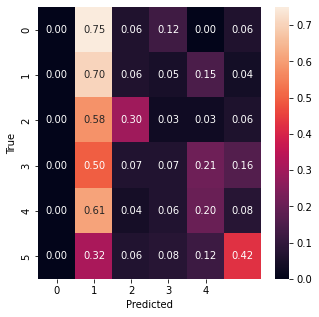

* Epoch 9 / 95


100%|██████████| 372/372 [02:00<00:00,  3.09it/s]


TRAIN - Time: 120.5s - Loss: 1.718284376526391


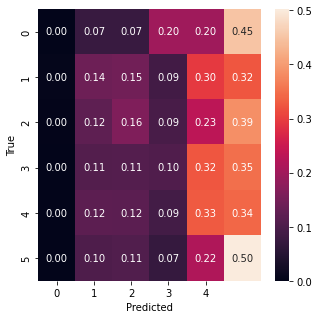

100%|██████████| 80/80 [00:13<00:00,  5.83it/s]


VALIDATION - Time: 13.7s - Loss: 1.7333743125200274


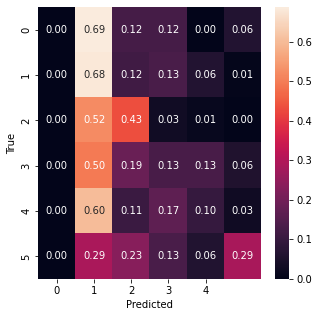

* Epoch 10 / 95


100%|██████████| 372/372 [02:01<00:00,  3.06it/s]


TRAIN - Time: 121.5s - Loss: 1.70321962109176


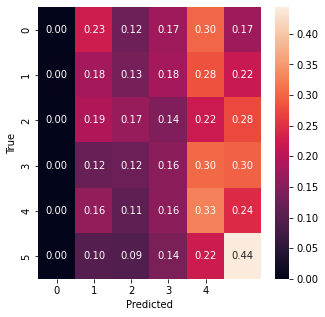

100%|██████████| 80/80 [00:13<00:00,  6.02it/s]


VALIDATION - Time: 13.3s - Loss: 1.681878046691418


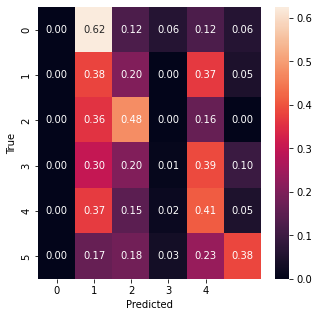

* Epoch 11 / 95


100%|██████████| 372/372 [02:01<00:00,  3.06it/s]


TRAIN - Time: 121.7s - Loss: 1.7060954009973872


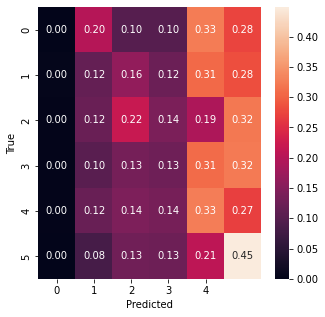

100%|██████████| 80/80 [00:13<00:00,  6.01it/s]


VALIDATION - Time: 13.3s - Loss: 1.7572291150689126


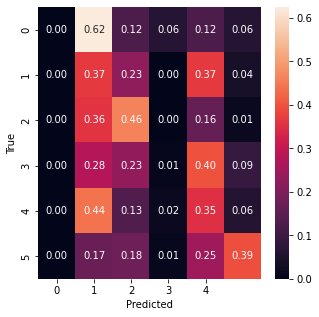

* Epoch 12 / 95


100%|██████████| 372/372 [01:59<00:00,  3.10it/s]


TRAIN - Time: 120.0s - Loss: 1.694731180385876


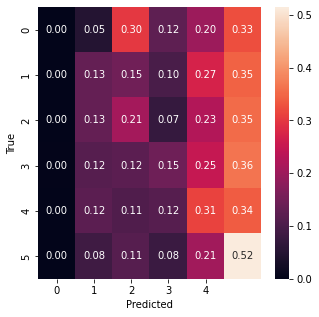

100%|██████████| 80/80 [00:13<00:00,  5.85it/s]


VALIDATION - Time: 13.7s - Loss: 1.702784878015518


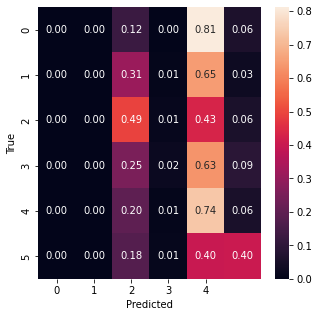

* Epoch 13 / 95


100%|██████████| 372/372 [02:01<00:00,  3.07it/s]


TRAIN - Time: 121.2s - Loss: 1.700380989620764


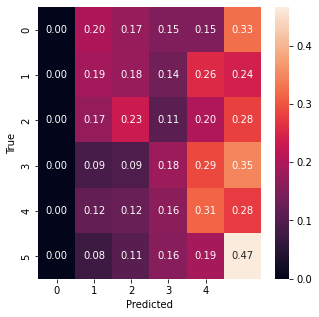

100%|██████████| 80/80 [00:13<00:00,  5.82it/s]


VALIDATION - Time: 13.8s - Loss: 1.6951596826314927


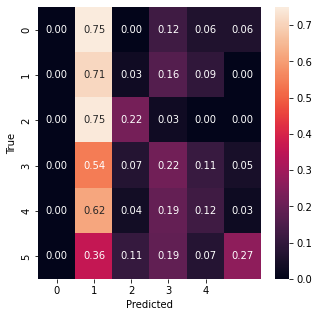

* Epoch 14 / 95


100%|██████████| 372/372 [02:01<00:00,  3.06it/s]


TRAIN - Time: 121.6s - Loss: 1.685470740641318


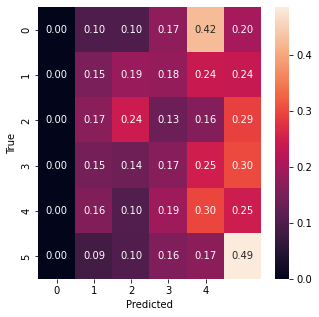

100%|██████████| 80/80 [00:13<00:00,  5.95it/s]


VALIDATION - Time: 13.4s - Loss: 1.7209776863455766


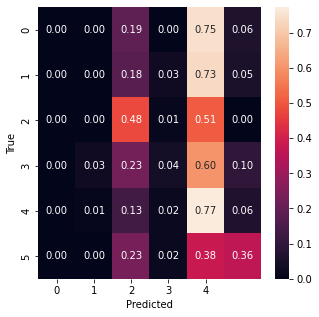

* Epoch 15 / 95


100%|██████████| 372/372 [02:00<00:00,  3.10it/s]


TRAIN - Time: 120.2s - Loss: 1.655281547897606


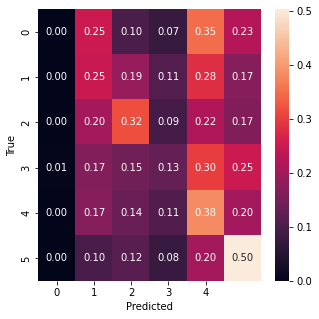

100%|██████████| 80/80 [00:13<00:00,  6.02it/s]


VALIDATION - Time: 13.3s - Loss: 1.7090456023812293


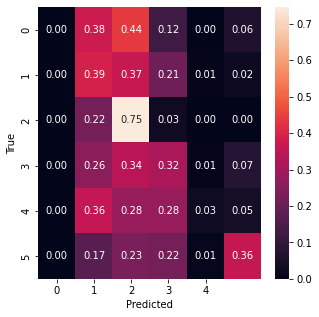

* Epoch 16 / 95


100%|██████████| 372/372 [02:01<00:00,  3.06it/s]


TRAIN - Time: 121.5s - Loss: 1.6451196741032357


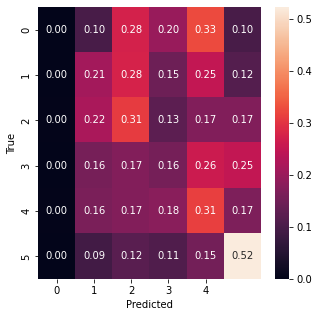

100%|██████████| 80/80 [00:13<00:00,  5.92it/s]


VALIDATION - Time: 13.5s - Loss: 1.6672142326831818


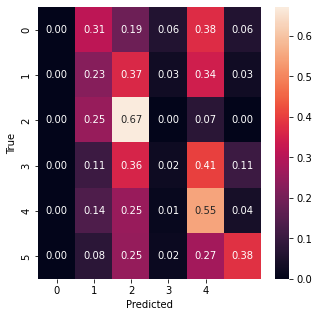

* Epoch 17 / 95


100%|██████████| 372/372 [02:01<00:00,  3.05it/s]


TRAIN - Time: 121.8s - Loss: 1.6458584576524706


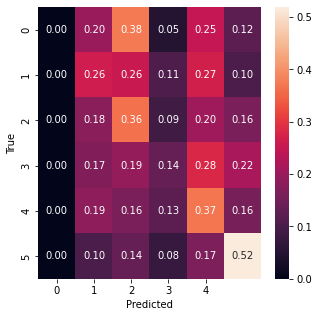

100%|██████████| 80/80 [00:13<00:00,  5.95it/s]


VALIDATION - Time: 13.5s - Loss: 1.6770826958119875


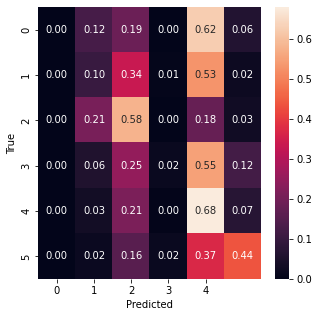

* Epoch 18 / 95


100%|██████████| 372/372 [02:01<00:00,  3.07it/s]


TRAIN - Time: 121.1s - Loss: 1.6395791166572173


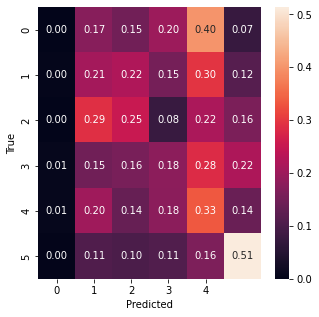

100%|██████████| 80/80 [00:13<00:00,  5.91it/s]


VALIDATION - Time: 13.5s - Loss: 1.6180867955088618


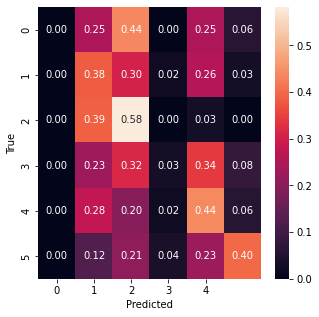

* Epoch 19 / 95


100%|██████████| 372/372 [02:02<00:00,  3.05it/s]


TRAIN - Time: 122.1s - Loss: 1.628126164918303


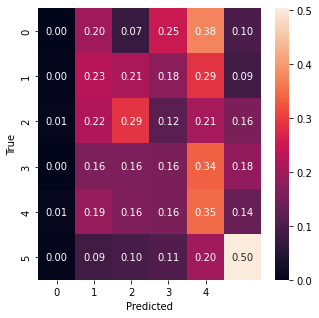

100%|██████████| 80/80 [00:13<00:00,  5.80it/s]


VALIDATION - Time: 13.8s - Loss: 1.6966236501932148


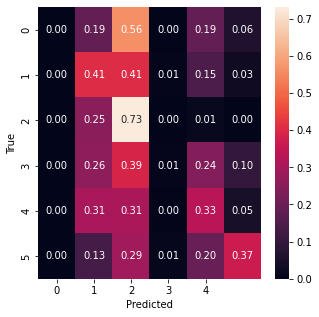

* Epoch 20 / 95


100%|██████████| 372/372 [02:01<00:00,  3.06it/s]


TRAIN - Time: 121.5s - Loss: 1.6134896403358825


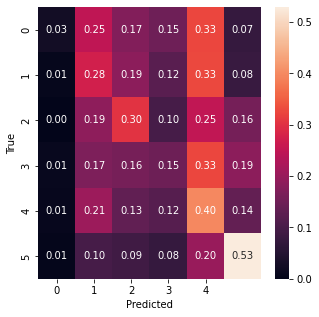

100%|██████████| 80/80 [00:13<00:00,  5.85it/s]


VALIDATION - Time: 13.7s - Loss: 1.6264019817113875


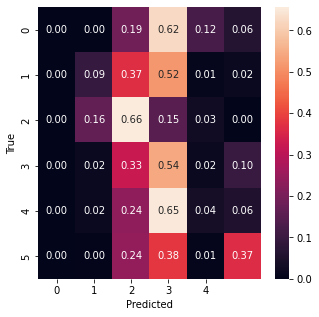

* Epoch 21 / 95


100%|██████████| 372/372 [02:00<00:00,  3.08it/s]


TRAIN - Time: 120.7s - Loss: 1.627613717509855


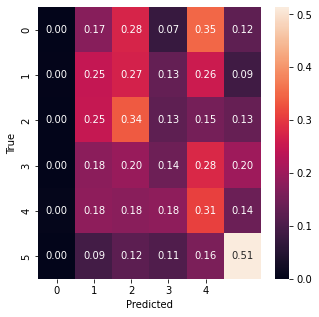

100%|██████████| 80/80 [00:13<00:00,  5.82it/s]


VALIDATION - Time: 13.8s - Loss: 1.647880756109953


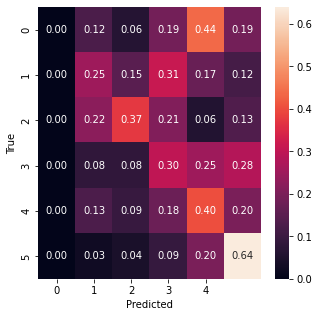

* Epoch 22 / 95


100%|██████████| 372/372 [02:01<00:00,  3.06it/s]


TRAIN - Time: 121.5s - Loss: 1.5983454982439667


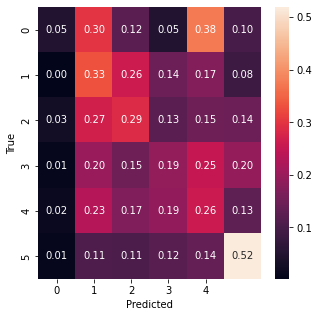

100%|██████████| 80/80 [00:13<00:00,  5.84it/s]


VALIDATION - Time: 13.7s - Loss: 1.5938641205430029


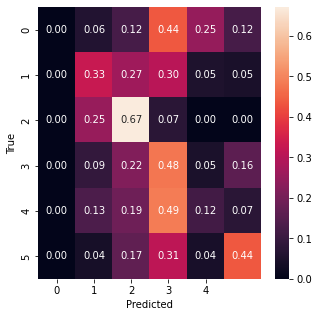

* Epoch 23 / 95


100%|██████████| 372/372 [02:02<00:00,  3.02it/s]


TRAIN - Time: 123.0s - Loss: 1.5944949670504498


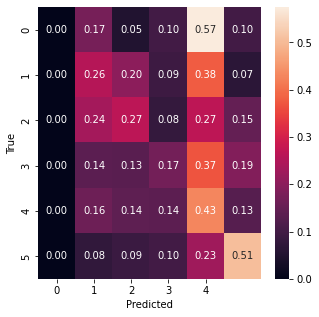

100%|██████████| 80/80 [00:13<00:00,  5.87it/s]


VALIDATION - Time: 13.6s - Loss: 1.6494226366281504


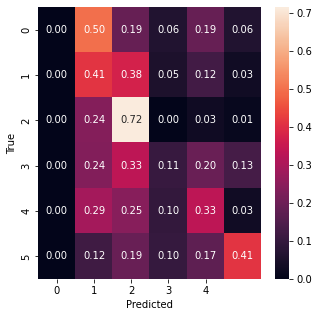

* Epoch 24 / 95


100%|██████████| 372/372 [02:00<00:00,  3.08it/s]


TRAIN - Time: 120.8s - Loss: 1.5818753479629424


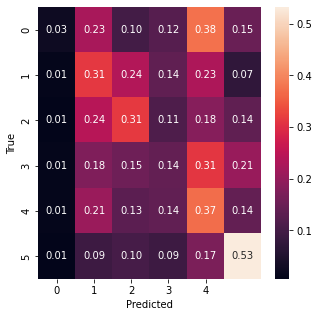

100%|██████████| 80/80 [00:13<00:00,  5.82it/s]


VALIDATION - Time: 13.7s - Loss: 1.594742747396231


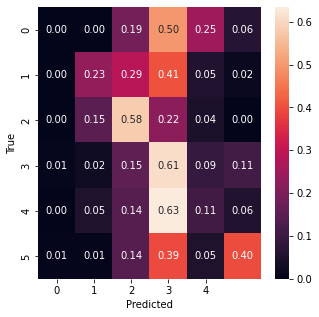

* Epoch 25 / 95


100%|██████████| 372/372 [02:02<00:00,  3.04it/s]


TRAIN - Time: 122.4s - Loss: 1.5792846199004877


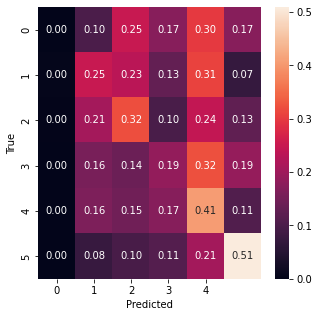

100%|██████████| 80/80 [00:13<00:00,  5.79it/s]


VALIDATION - Time: 13.8s - Loss: 1.5378645882010458


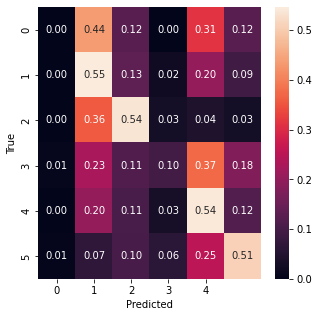

* Epoch 26 / 95


100%|██████████| 372/372 [02:02<00:00,  3.03it/s]


TRAIN - Time: 122.9s - Loss: 1.5793138442821428


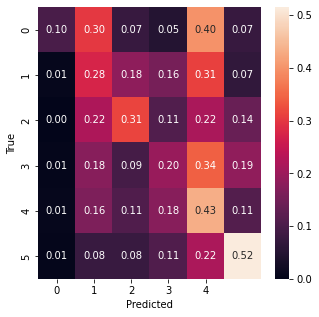

100%|██████████| 80/80 [00:13<00:00,  5.95it/s]


VALIDATION - Time: 13.5s - Loss: 1.6053233414888382


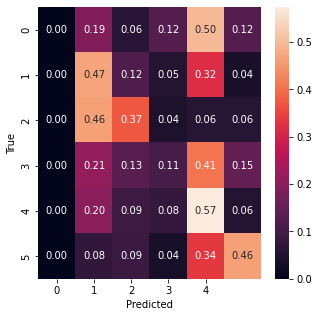

* Epoch 27 / 95


100%|██████████| 372/372 [02:02<00:00,  3.05it/s]


TRAIN - Time: 122.0s - Loss: 1.5658252322545607


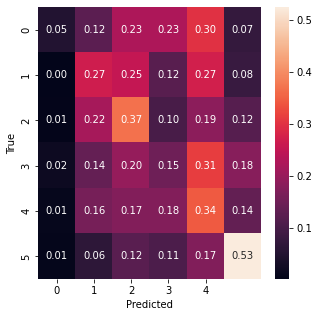

100%|██████████| 80/80 [00:14<00:00,  5.61it/s]


VALIDATION - Time: 14.3s - Loss: 1.621808983385563


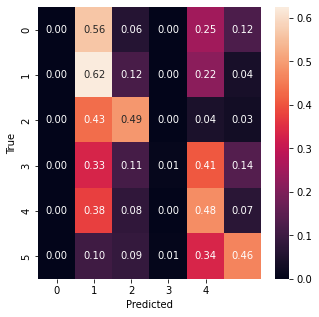

* Epoch 28 / 95


100%|██████████| 372/372 [02:01<00:00,  3.05it/s]


TRAIN - Time: 121.8s - Loss: 1.5782149720896963


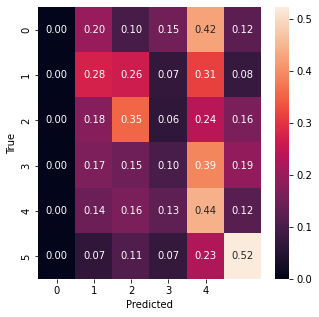

100%|██████████| 80/80 [00:13<00:00,  5.81it/s]


VALIDATION - Time: 13.8s - Loss: 1.5628426268696787


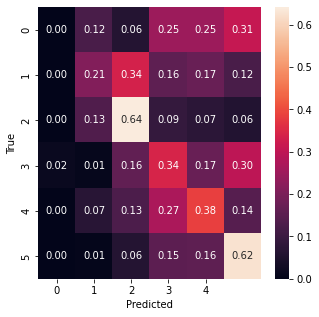

* Epoch 29 / 95


100%|██████████| 372/372 [02:03<00:00,  3.02it/s]


TRAIN - Time: 123.3s - Loss: 1.573947009700601


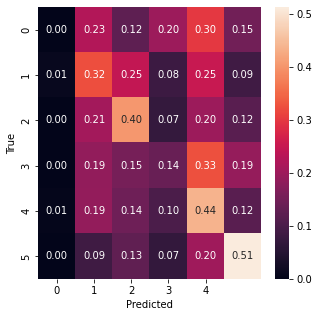

100%|██████████| 80/80 [00:13<00:00,  5.87it/s]


VALIDATION - Time: 13.6s - Loss: 1.549210043996572


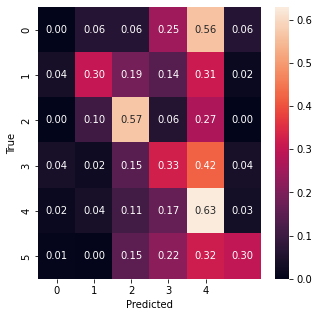

* Epoch 30 / 95


100%|██████████| 372/372 [02:02<00:00,  3.04it/s]


TRAIN - Time: 122.2s - Loss: 1.5470675239639895


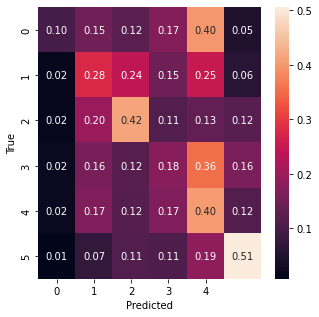

100%|██████████| 80/80 [00:15<00:00,  5.19it/s]


VALIDATION - Time: 15.4s - Loss: 1.5504019893705843


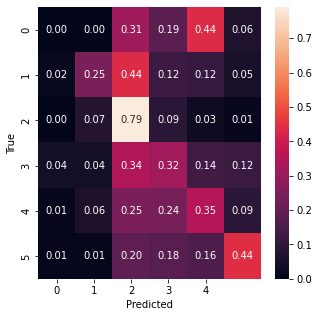

* Epoch 31 / 95


100%|██████████| 372/372 [02:02<00:00,  3.04it/s]


TRAIN - Time: 122.5s - Loss: 1.5374982914616968


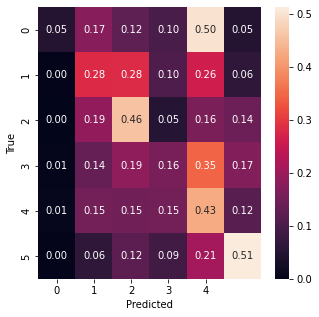

100%|██████████| 80/80 [00:14<00:00,  5.64it/s]


VALIDATION - Time: 14.2s - Loss: 1.5473022744059561


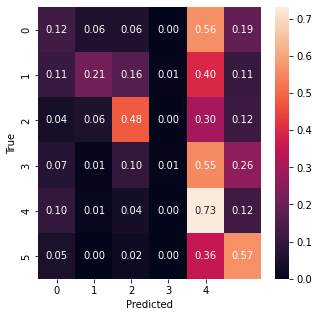

* Epoch 32 / 95


100%|██████████| 372/372 [02:04<00:00,  2.99it/s]


TRAIN - Time: 124.6s - Loss: 1.5293581545032497


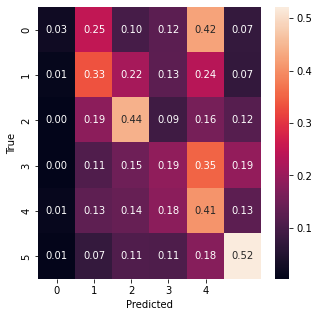

100%|██████████| 80/80 [00:14<00:00,  5.56it/s]


VALIDATION - Time: 14.4s - Loss: 1.5383616417646409


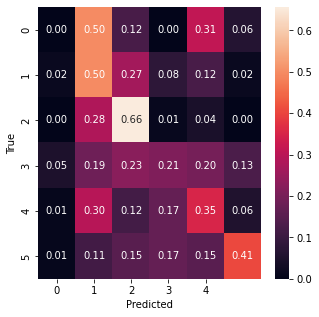

* Epoch 33 / 95


100%|██████████| 372/372 [02:04<00:00,  2.99it/s]


TRAIN - Time: 124.6s - Loss: 1.5334718935592193


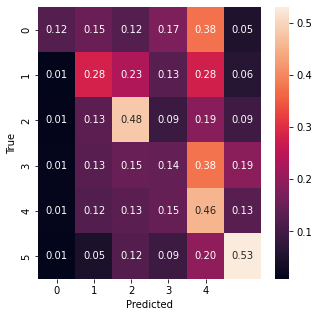

100%|██████████| 80/80 [00:13<00:00,  5.73it/s]


VALIDATION - Time: 14.0s - Loss: 1.5405457347631457


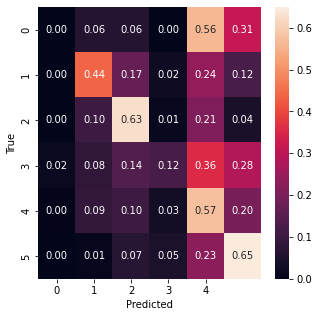

* Epoch 34 / 95


100%|██████████| 372/372 [02:02<00:00,  3.04it/s]


TRAIN - Time: 122.5s - Loss: 1.5416932339950284


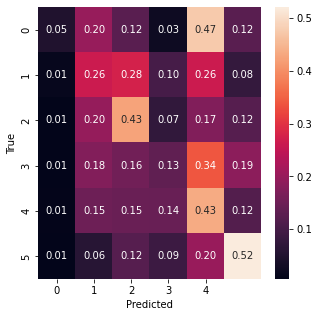

100%|██████████| 80/80 [00:13<00:00,  5.73it/s]


VALIDATION - Time: 14.0s - Loss: 1.5865381799638267


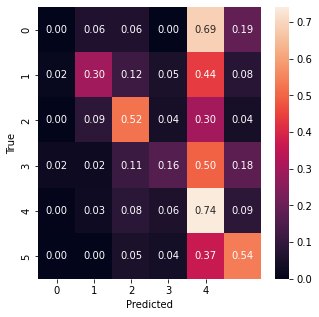

* Epoch 35 / 95


100%|██████████| 372/372 [02:04<00:00,  2.99it/s]


TRAIN - Time: 124.4s - Loss: 1.5265065300208271


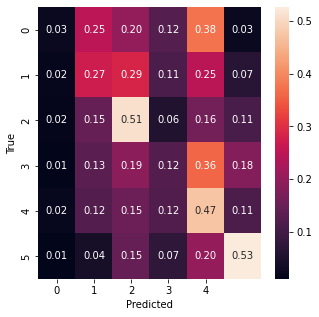

100%|██████████| 80/80 [00:14<00:00,  5.64it/s]


VALIDATION - Time: 14.2s - Loss: 1.5084632858633997


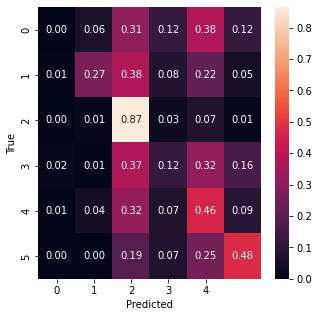

* Epoch 36 / 95


100%|██████████| 372/372 [02:05<00:00,  2.97it/s]


TRAIN - Time: 125.2s - Loss: 1.529142729377234


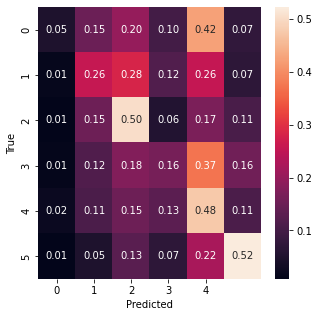

100%|██████████| 80/80 [00:14<00:00,  5.66it/s]


VALIDATION - Time: 14.1s - Loss: 1.5613459028303627


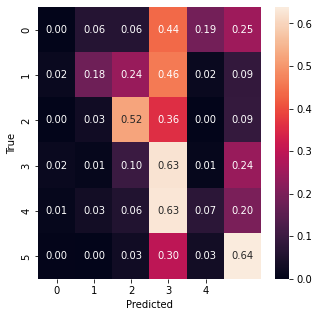

* Epoch 37 / 95


100%|██████████| 372/372 [02:03<00:00,  3.01it/s]


TRAIN - Time: 123.5s - Loss: 1.516367786033179


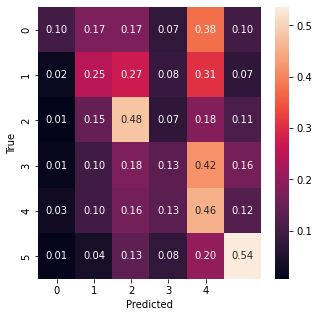

100%|██████████| 80/80 [00:14<00:00,  5.57it/s]


VALIDATION - Time: 14.4s - Loss: 1.528075423836708


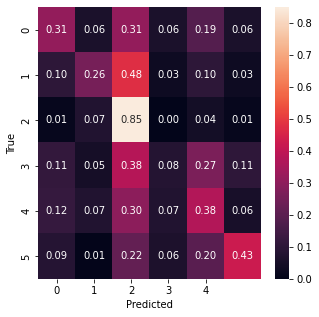

* Epoch 38 / 95


100%|██████████| 372/372 [02:05<00:00,  2.96it/s]


TRAIN - Time: 125.7s - Loss: 1.5078482445209258


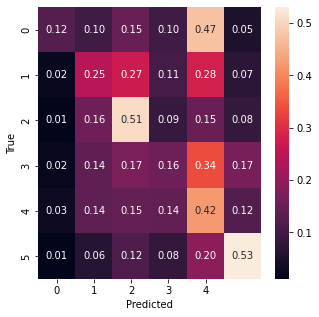

100%|██████████| 80/80 [00:14<00:00,  5.54it/s]


VALIDATION - Time: 14.4s - Loss: 1.498591040074825


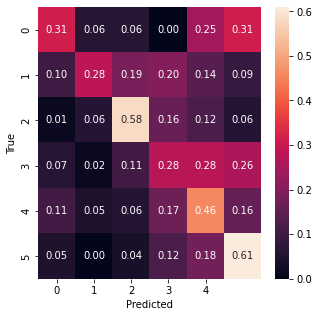

* Epoch 39 / 95


100%|██████████| 372/372 [02:05<00:00,  2.96it/s]


TRAIN - Time: 125.6s - Loss: 1.519051443665259


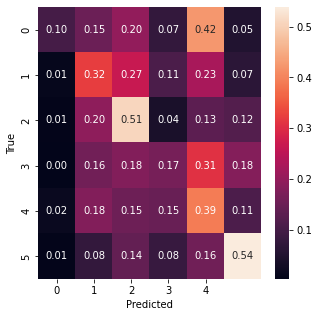

100%|██████████| 80/80 [00:14<00:00,  5.65it/s]


VALIDATION - Time: 14.2s - Loss: 1.5465473912656305


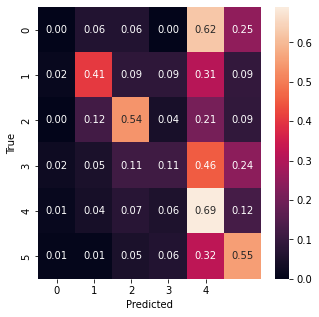

* Epoch 40 / 95


100%|██████████| 372/372 [02:03<00:00,  3.00it/s]


TRAIN - Time: 124.0s - Loss: 1.505112638877286


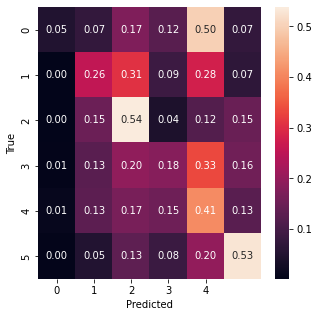

100%|██████████| 80/80 [00:14<00:00,  5.49it/s]


VALIDATION - Time: 14.6s - Loss: 1.5036878503859044


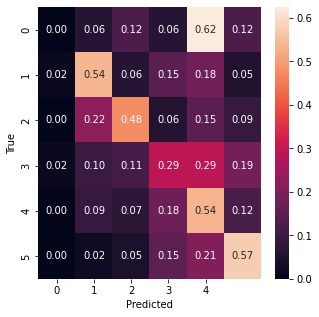

* Epoch 41 / 95


100%|██████████| 372/372 [02:04<00:00,  2.99it/s]


TRAIN - Time: 124.6s - Loss: 1.4985897661216792


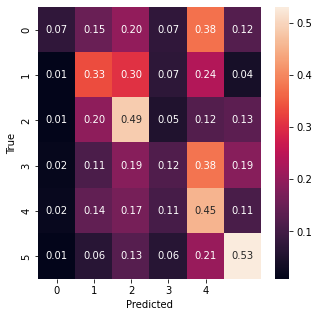

100%|██████████| 80/80 [00:14<00:00,  5.60it/s]


VALIDATION - Time: 14.3s - Loss: 1.4714169107377526


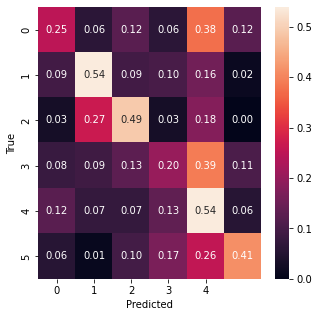

* Epoch 42 / 95


100%|██████████| 372/372 [02:06<00:00,  2.93it/s]


TRAIN - Time: 126.8s - Loss: 1.5028246067544468


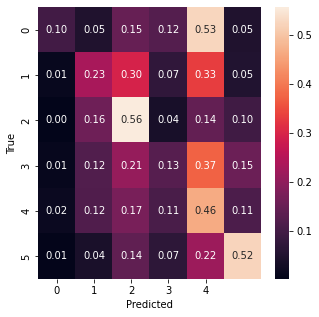

100%|██████████| 80/80 [00:14<00:00,  5.63it/s]


VALIDATION - Time: 14.2s - Loss: 1.4885565757751464


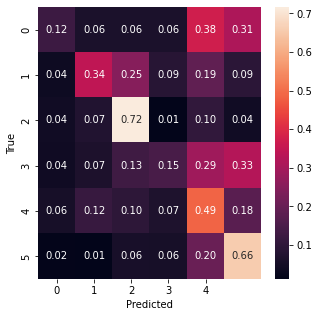

* Epoch 43 / 95


100%|██████████| 372/372 [02:04<00:00,  2.98it/s]


TRAIN - Time: 124.7s - Loss: 1.4951526142897136


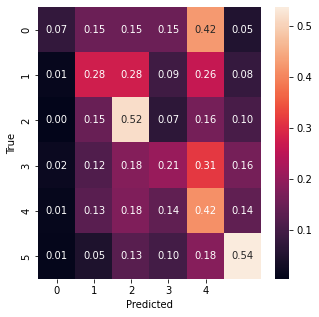

100%|██████████| 80/80 [00:15<00:00,  5.16it/s]


VALIDATION - Time: 15.5s - Loss: 1.5533631220459934


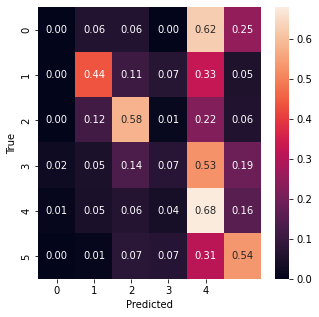

* Epoch 44 / 95


100%|██████████| 372/372 [02:06<00:00,  2.95it/s]


TRAIN - Time: 126.2s - Loss: 1.505416318613995


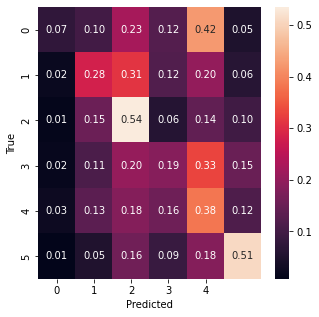

100%|██████████| 80/80 [00:14<00:00,  5.35it/s]


VALIDATION - Time: 15.0s - Loss: 1.5708799310028556


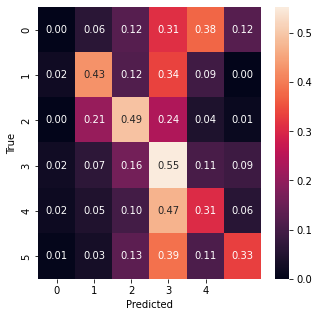

* Epoch 45 / 95


100%|██████████| 372/372 [02:05<00:00,  2.97it/s]


TRAIN - Time: 125.2s - Loss: 1.4738346293408395


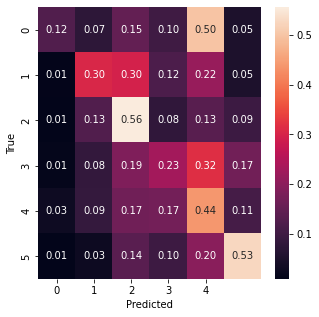

100%|██████████| 80/80 [00:13<00:00,  5.72it/s]


VALIDATION - Time: 14.0s - Loss: 1.44611124843359


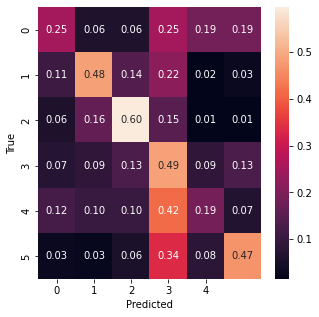

* Epoch 46 / 95


100%|██████████| 372/372 [02:07<00:00,  2.93it/s]


TRAIN - Time: 127.0s - Loss: 1.4843680658327636


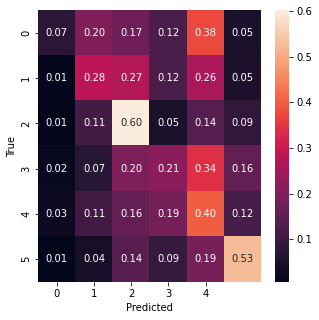

100%|██████████| 80/80 [00:14<00:00,  5.61it/s]


VALIDATION - Time: 14.3s - Loss: 1.4578444927930834


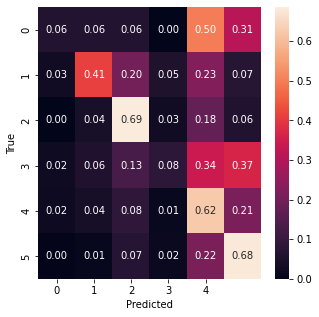

* Epoch 47 / 95


100%|██████████| 372/372 [02:03<00:00,  3.00it/s]


TRAIN - Time: 124.0s - Loss: 1.4737434718878029


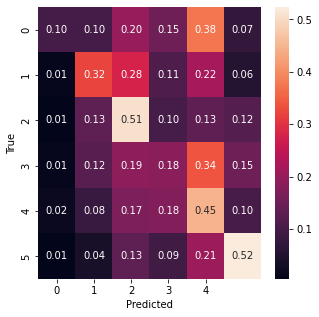

100%|██████████| 80/80 [00:14<00:00,  5.56it/s]


VALIDATION - Time: 14.4s - Loss: 1.4697421140968794


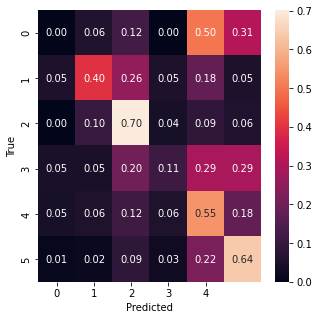

* Epoch 48 / 95


100%|██████████| 372/372 [02:05<00:00,  2.96it/s]


TRAIN - Time: 125.8s - Loss: 1.4546353970804522


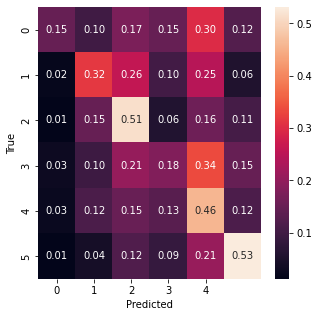

100%|██████████| 80/80 [00:15<00:00,  5.20it/s]


VALIDATION - Time: 15.4s - Loss: 1.5658581890165806


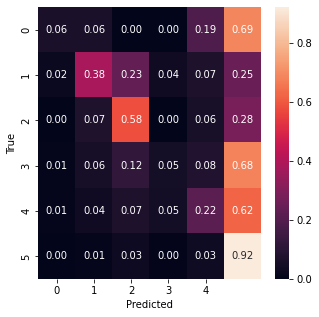

* Epoch 49 / 95


100%|██████████| 372/372 [02:04<00:00,  2.98it/s]


TRAIN - Time: 124.8s - Loss: 1.4728825380725246


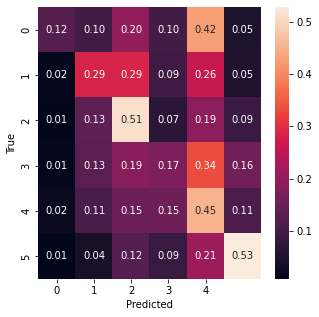

100%|██████████| 80/80 [00:14<00:00,  5.49it/s]


VALIDATION - Time: 14.6s - Loss: 1.5034971013665197


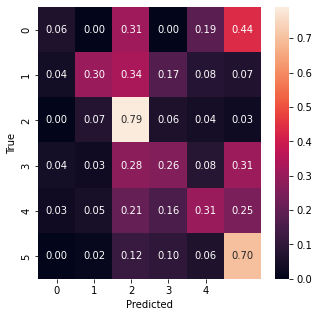

* Epoch 50 / 95


100%|██████████| 372/372 [02:04<00:00,  2.99it/s]


TRAIN - Time: 124.5s - Loss: 1.4756159167135914


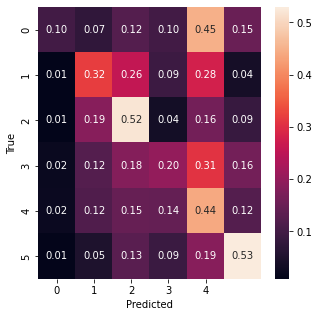

100%|██████████| 80/80 [00:14<00:00,  5.58it/s]


VALIDATION - Time: 14.3s - Loss: 1.5339194603264334


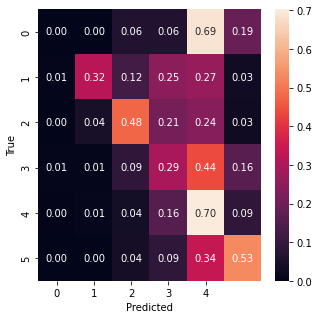

* Epoch 51 / 95


100%|██████████| 372/372 [02:05<00:00,  2.96it/s]


TRAIN - Time: 125.7s - Loss: 1.4828326429731102


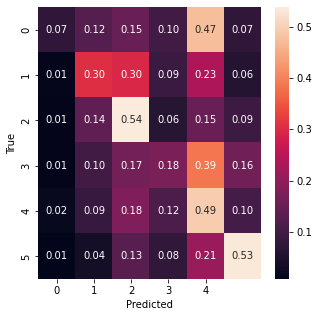

100%|██████████| 80/80 [00:14<00:00,  5.48it/s]


VALIDATION - Time: 14.6s - Loss: 1.4591320462524886


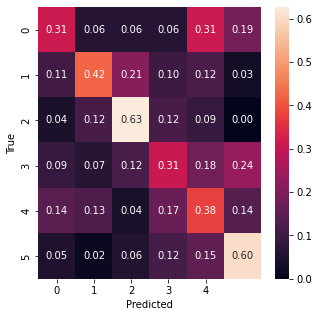

* Epoch 52 / 95


100%|██████████| 372/372 [02:05<00:00,  2.95it/s]


TRAIN - Time: 125.9s - Loss: 1.4605382682495227


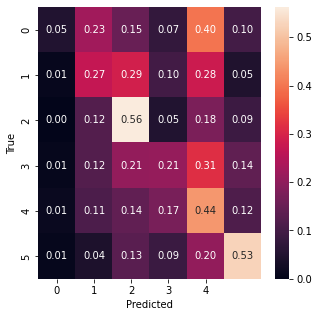

100%|██████████| 80/80 [00:14<00:00,  5.56it/s]


VALIDATION - Time: 14.4s - Loss: 1.4422275915741918


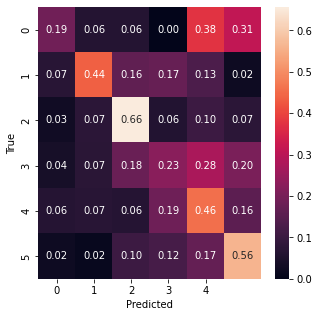

* Epoch 53 / 95


100%|██████████| 372/372 [02:05<00:00,  2.96it/s]


TRAIN - Time: 125.9s - Loss: 1.4690759662658937


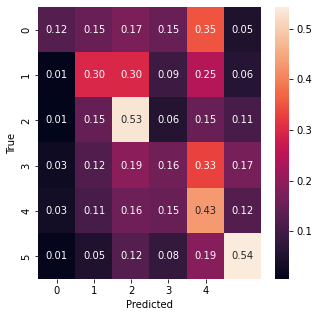

100%|██████████| 80/80 [00:14<00:00,  5.54it/s]


VALIDATION - Time: 14.5s - Loss: 1.4583174280822275


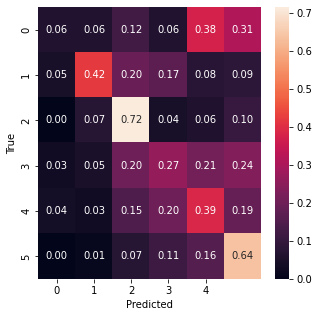

* Epoch 54 / 95


100%|██████████| 372/372 [02:04<00:00,  2.99it/s]


TRAIN - Time: 124.3s - Loss: 1.4577587498452076


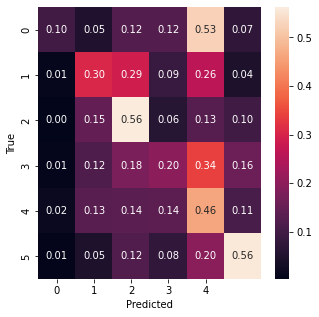

100%|██████████| 80/80 [00:13<00:00,  5.74it/s]


VALIDATION - Time: 14.0s - Loss: 1.4483048394322395


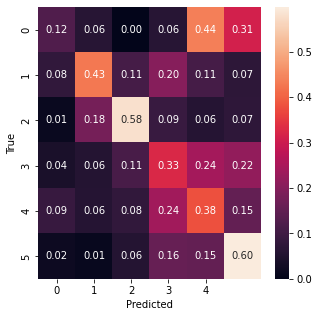

* Epoch 55 / 95


100%|██████████| 372/372 [02:05<00:00,  2.97it/s]


TRAIN - Time: 125.3s - Loss: 1.4666916101530043


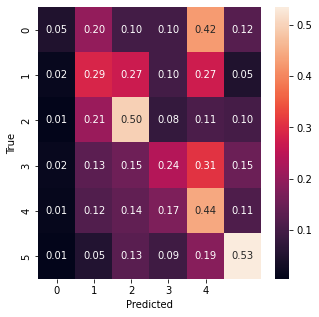

100%|██████████| 80/80 [00:14<00:00,  5.58it/s]


VALIDATION - Time: 14.4s - Loss: 1.598122201114893


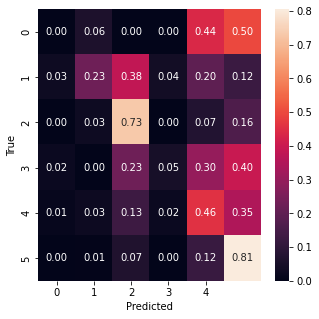

* Epoch 56 / 95


100%|██████████| 372/372 [02:04<00:00,  2.99it/s]


TRAIN - Time: 124.4s - Loss: 1.469481559850836


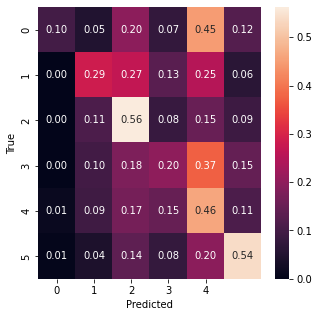

100%|██████████| 80/80 [00:16<00:00,  4.99it/s]


VALIDATION - Time: 16.1s - Loss: 1.4367221541702748


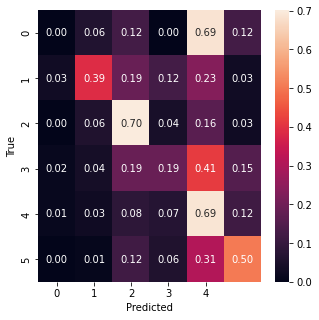

* Epoch 57 / 95


100%|██████████| 372/372 [02:05<00:00,  2.97it/s]


TRAIN - Time: 125.2s - Loss: 1.4435328727447845


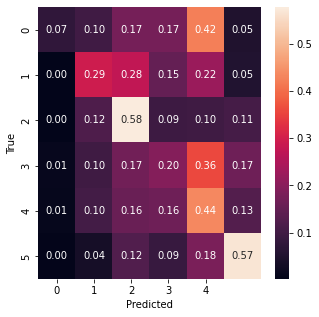

100%|██████████| 80/80 [00:14<00:00,  5.59it/s]


VALIDATION - Time: 14.3s - Loss: 1.4691728428006172


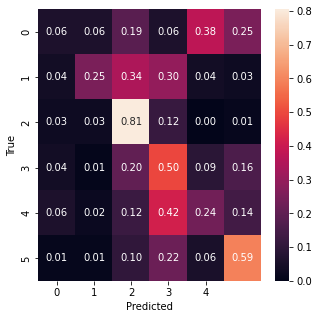

* Epoch 58 / 95


100%|██████████| 372/372 [02:04<00:00,  2.98it/s]


TRAIN - Time: 125.0s - Loss: 1.4408443600580252


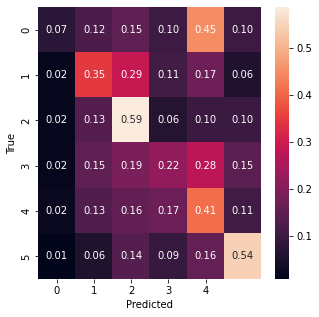

100%|██████████| 80/80 [00:14<00:00,  5.44it/s]


VALIDATION - Time: 14.7s - Loss: 1.4285513870418074


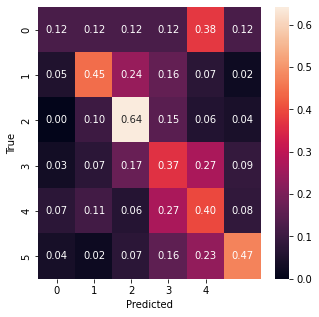

* Epoch 59 / 95


100%|██████████| 372/372 [02:06<00:00,  2.94it/s]


TRAIN - Time: 126.6s - Loss: 1.4252656819999858


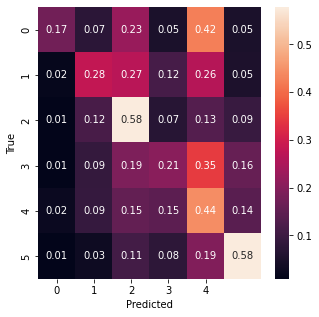

100%|██████████| 80/80 [00:14<00:00,  5.68it/s]


VALIDATION - Time: 14.1s - Loss: 1.43661974966526


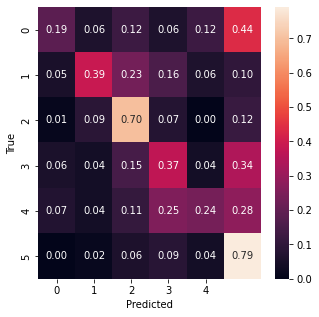

* Epoch 60 / 95


100%|██████████| 372/372 [02:04<00:00,  3.00it/s]


TRAIN - Time: 124.2s - Loss: 1.4615907587351342


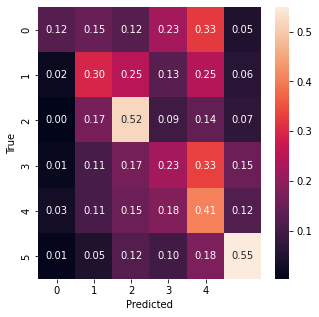

100%|██████████| 80/80 [00:14<00:00,  5.58it/s]


VALIDATION - Time: 14.3s - Loss: 1.4555642656981944


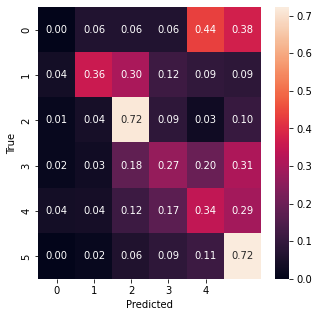

* Epoch 61 / 95


100%|██████████| 372/372 [02:06<00:00,  2.95it/s]


TRAIN - Time: 126.2s - Loss: 1.450541232702552


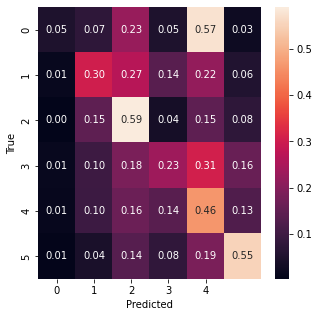

100%|██████████| 80/80 [00:15<00:00,  5.23it/s]


VALIDATION - Time: 15.3s - Loss: 1.4652564860880373


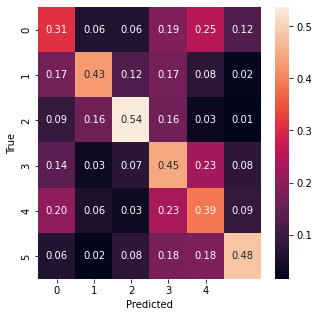

* Epoch 62 / 95


100%|██████████| 372/372 [02:07<00:00,  2.92it/s]


TRAIN - Time: 127.3s - Loss: 1.4264337854680191


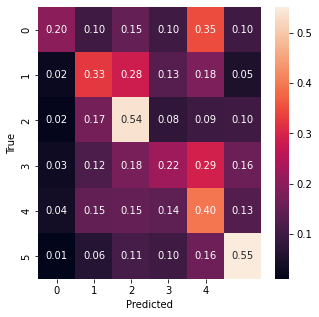

100%|██████████| 80/80 [00:14<00:00,  5.34it/s]


VALIDATION - Time: 15.0s - Loss: 1.5251630403101446


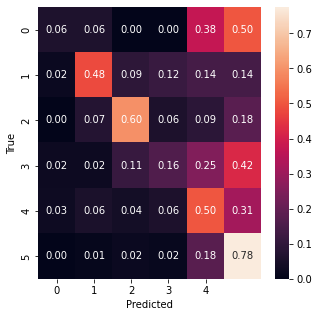

* Epoch 63 / 95


100%|██████████| 372/372 [02:06<00:00,  2.95it/s]


TRAIN - Time: 126.2s - Loss: 1.446745482663955


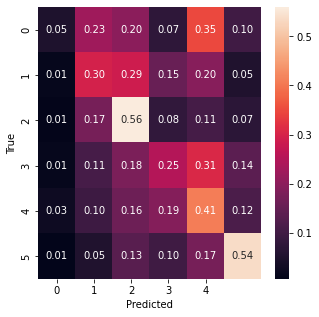

100%|██████████| 80/80 [00:14<00:00,  5.41it/s]


VALIDATION - Time: 14.8s - Loss: 1.4901286587119098


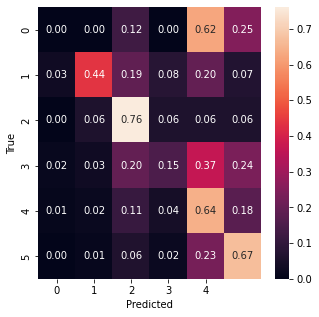

* Epoch 64 / 95


100%|██████████| 372/372 [02:06<00:00,  2.95it/s]


TRAIN - Time: 126.1s - Loss: 1.4179299393648759


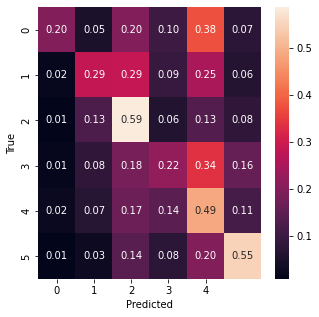

100%|██████████| 80/80 [00:14<00:00,  5.50it/s]


VALIDATION - Time: 14.6s - Loss: 1.4460808008909227


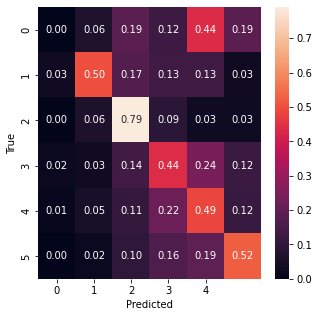

* Epoch 65 / 95


100%|██████████| 372/372 [02:15<00:00,  2.74it/s]


TRAIN - Time: 135.7s - Loss: 1.4437920633823644


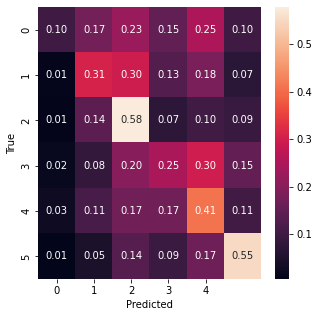

100%|██████████| 80/80 [00:14<00:00,  5.43it/s]


VALIDATION - Time: 14.7s - Loss: 1.4737201958894737


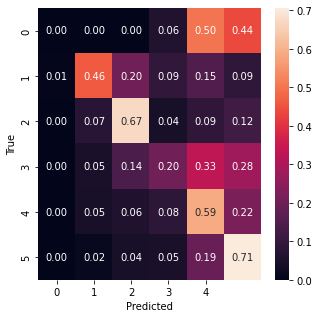

* Epoch 66 / 95


100%|██████████| 372/372 [02:05<00:00,  2.97it/s]


TRAIN - Time: 125.3s - Loss: 1.4209941341992327


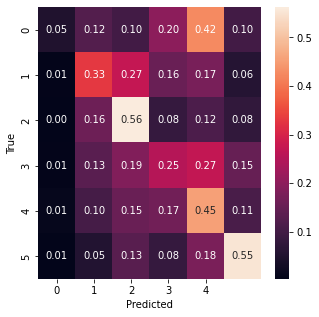

100%|██████████| 80/80 [00:14<00:00,  5.48it/s]


VALIDATION - Time: 14.6s - Loss: 1.3989251032471661


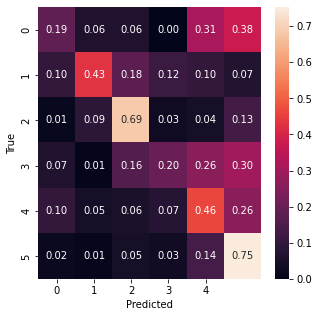

* Epoch 67 / 95


100%|██████████| 372/372 [02:09<00:00,  2.86it/s]


TRAIN - Time: 130.0s - Loss: 1.417666819787795


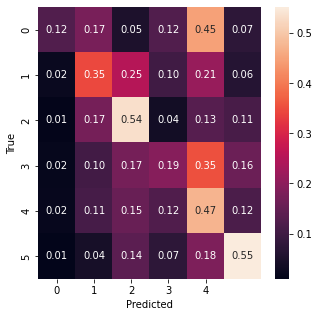

100%|██████████| 80/80 [00:15<00:00,  5.33it/s]


VALIDATION - Time: 15.0s - Loss: 1.4241641022264957


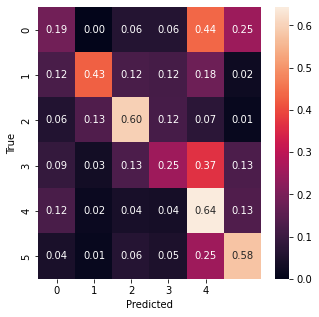

* Epoch 68 / 95


100%|██████████| 372/372 [02:07<00:00,  2.91it/s]


TRAIN - Time: 127.8s - Loss: 1.408560231808694


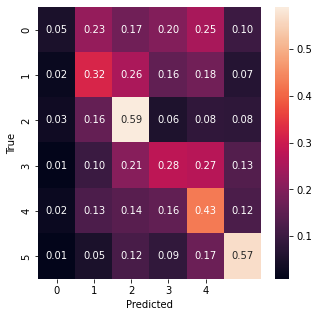

100%|██████████| 80/80 [00:14<00:00,  5.46it/s]


VALIDATION - Time: 14.7s - Loss: 1.4554818443953994


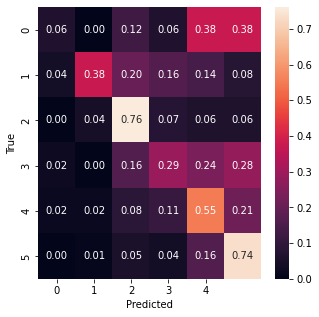

* Epoch 69 / 95


100%|██████████| 372/372 [02:06<00:00,  2.95it/s]


TRAIN - Time: 126.1s - Loss: 1.3878795092785223


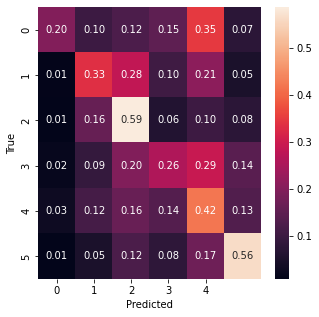

100%|██████████| 80/80 [00:15<00:00,  5.29it/s]


VALIDATION - Time: 15.1s - Loss: 1.436837100982666


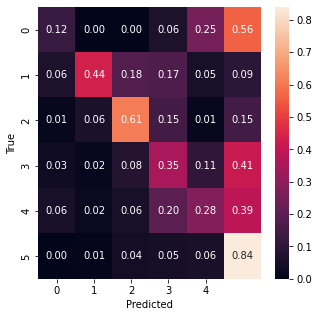

* Epoch 70 / 95


100%|██████████| 372/372 [02:06<00:00,  2.93it/s]


TRAIN - Time: 126.8s - Loss: 1.3975649266153258


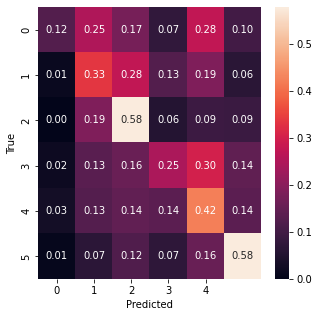

100%|██████████| 80/80 [00:14<00:00,  5.40it/s]


VALIDATION - Time: 14.8s - Loss: 1.51684795692563


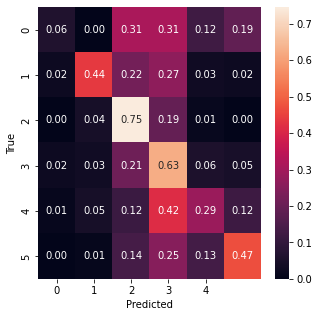

* Epoch 71 / 95


100%|██████████| 372/372 [02:08<00:00,  2.89it/s]


TRAIN - Time: 128.7s - Loss: 1.3921832626545305


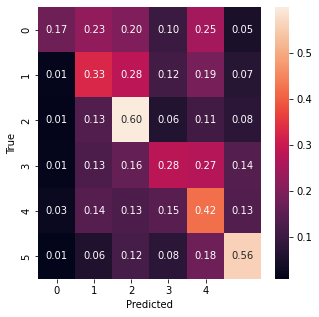

100%|██████████| 80/80 [00:14<00:00,  5.44it/s]


VALIDATION - Time: 14.7s - Loss: 1.4516361154615882


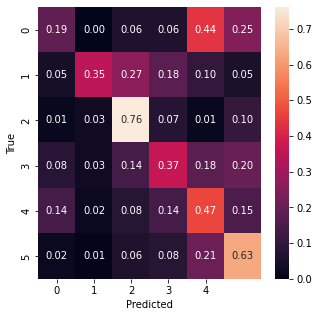

* Epoch 72 / 95


100%|██████████| 372/372 [02:07<00:00,  2.93it/s]


TRAIN - Time: 127.1s - Loss: 1.3830021542887527


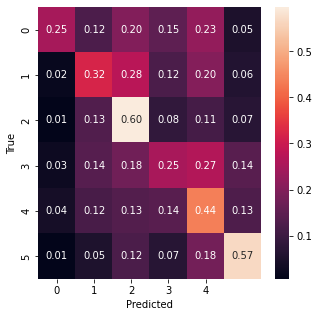

100%|██████████| 80/80 [00:14<00:00,  5.42it/s]


VALIDATION - Time: 14.8s - Loss: 1.4841275602579116


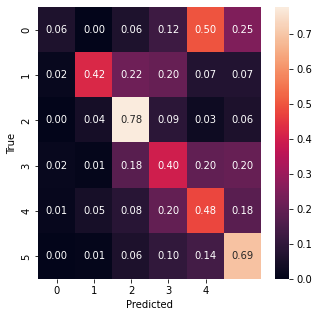

* Epoch 73 / 95


100%|██████████| 372/372 [02:09<00:00,  2.87it/s]


TRAIN - Time: 129.7s - Loss: 1.390299671279487


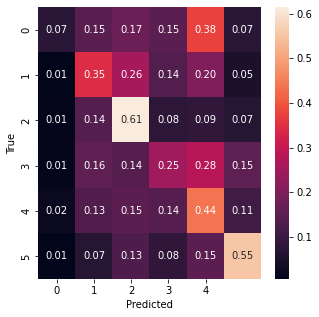

100%|██████████| 80/80 [00:15<00:00,  5.32it/s]


VALIDATION - Time: 15.1s - Loss: 1.533589099347591


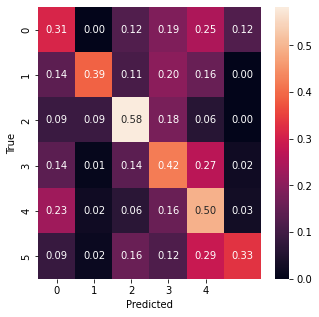

* Epoch 74 / 95


100%|██████████| 372/372 [02:07<00:00,  2.91it/s]


TRAIN - Time: 128.0s - Loss: 1.4003616947961097


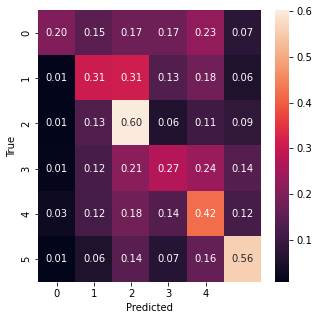

100%|██████████| 80/80 [00:15<00:00,  5.32it/s]


VALIDATION - Time: 15.0s - Loss: 1.427204144001007


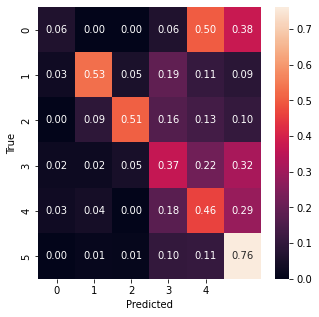

* Epoch 75 / 95


100%|██████████| 372/372 [02:08<00:00,  2.90it/s]


TRAIN - Time: 128.2s - Loss: 1.3997573825300387


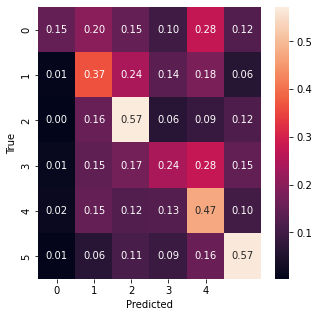

100%|██████████| 80/80 [00:15<00:00,  5.29it/s]


VALIDATION - Time: 15.1s - Loss: 1.420512981712818


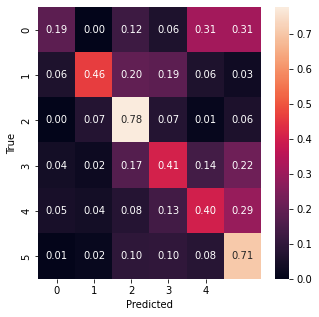

* Epoch 76 / 95


100%|██████████| 372/372 [02:08<00:00,  2.89it/s]


TRAIN - Time: 128.9s - Loss: 1.4179176195494592


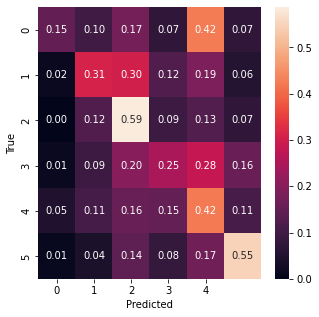

100%|██████████| 80/80 [00:15<00:00,  5.25it/s]


VALIDATION - Time: 15.3s - Loss: 1.360567182302475


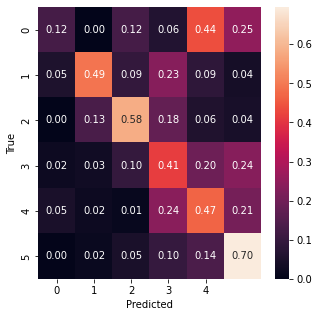

* Epoch 77 / 95


100%|██████████| 372/372 [02:07<00:00,  2.92it/s]


TRAIN - Time: 127.3s - Loss: 1.3916721819869948


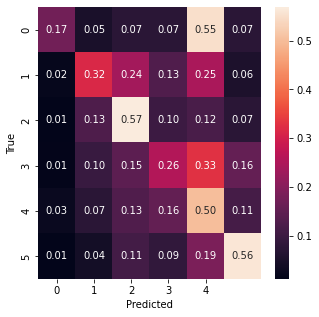

100%|██████████| 80/80 [00:14<00:00,  5.40it/s]


VALIDATION - Time: 14.8s - Loss: 1.4302231095731264


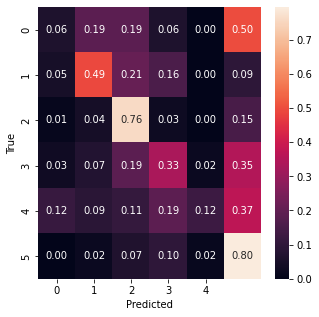

* Epoch 78 / 95


100%|██████████| 372/372 [02:08<00:00,  2.90it/s]


TRAIN - Time: 128.2s - Loss: 1.3929830328110724


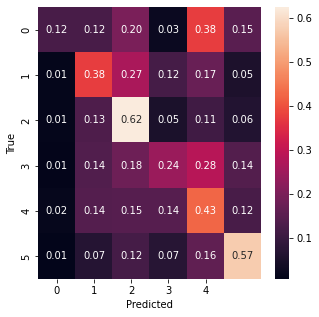

100%|██████████| 80/80 [00:14<00:00,  5.36it/s]


VALIDATION - Time: 14.9s - Loss: 1.360626436769962


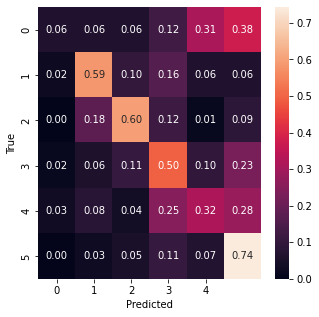

* Epoch 79 / 95


100%|██████████| 372/372 [02:07<00:00,  2.92it/s]


TRAIN - Time: 127.4s - Loss: 1.385136512498702


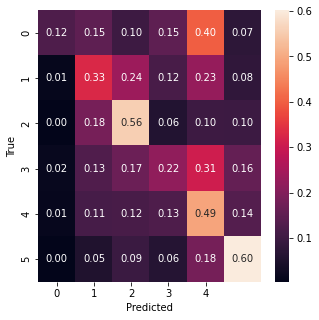

100%|██████████| 80/80 [00:17<00:00,  4.67it/s]


VALIDATION - Time: 17.1s - Loss: 1.4112604729831224


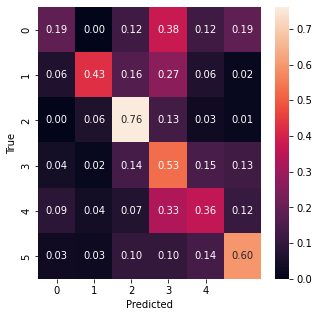

* Epoch 80 / 95


100%|██████████| 372/372 [02:06<00:00,  2.93it/s]


TRAIN - Time: 127.0s - Loss: 1.3747896931825145


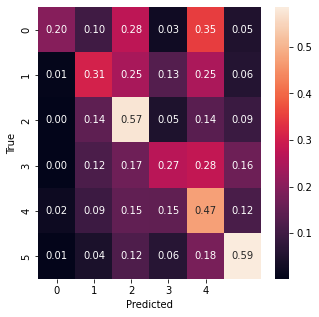

100%|██████████| 80/80 [00:14<00:00,  5.37it/s]


VALIDATION - Time: 14.9s - Loss: 1.4786664590239524


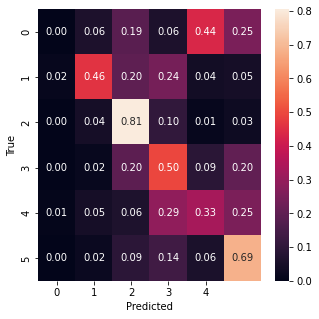

* Epoch 81 / 95


100%|██████████| 372/372 [02:08<00:00,  2.89it/s]


TRAIN - Time: 128.6s - Loss: 1.3809366917578112


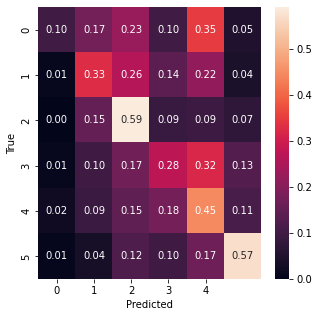

100%|██████████| 80/80 [00:14<00:00,  5.37it/s]


VALIDATION - Time: 14.9s - Loss: 1.3653447877615692


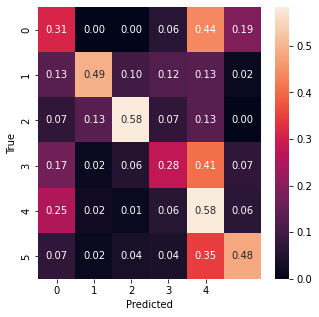

* Epoch 82 / 95


100%|██████████| 372/372 [02:07<00:00,  2.92it/s]


TRAIN - Time: 127.4s - Loss: 1.3967488686884597


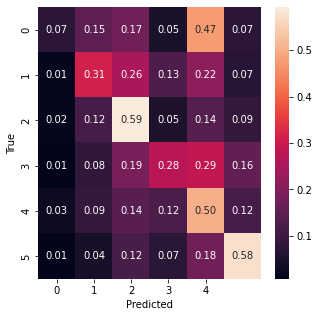

100%|██████████| 80/80 [00:15<00:00,  5.24it/s]


VALIDATION - Time: 15.3s - Loss: 1.4007795311510562


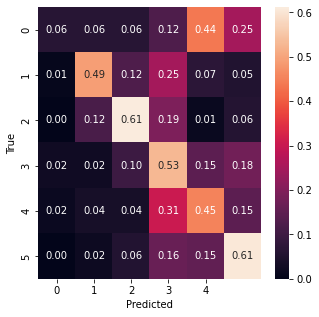

* Epoch 83 / 95


100%|██████████| 372/372 [02:06<00:00,  2.93it/s]


TRAIN - Time: 127.0s - Loss: 1.3584538669355464


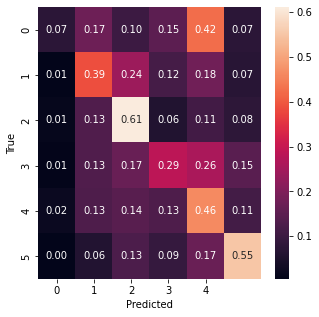

100%|██████████| 80/80 [00:14<00:00,  5.35it/s]


VALIDATION - Time: 15.0s - Loss: 1.4705136977136137


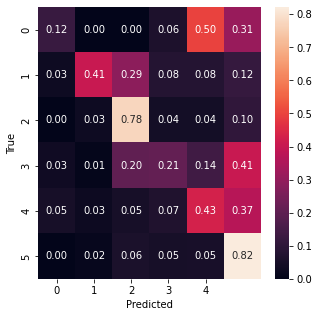

* Epoch 84 / 95


100%|██████████| 372/372 [02:06<00:00,  2.94it/s]


TRAIN - Time: 126.5s - Loss: 1.3548070011279911


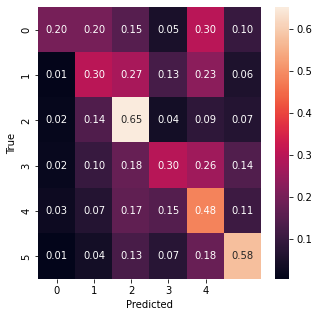

100%|██████████| 80/80 [00:15<00:00,  5.26it/s]


VALIDATION - Time: 15.2s - Loss: 1.4178941413760184


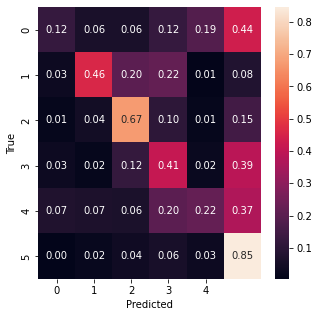

* Epoch 85 / 95


100%|██████████| 372/372 [02:07<00:00,  2.92it/s]


TRAIN - Time: 127.3s - Loss: 1.3556283810125889


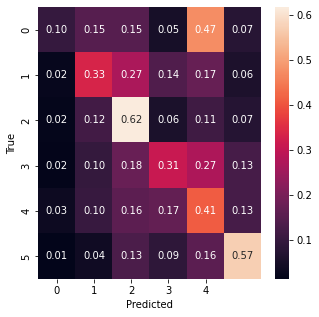

100%|██████████| 80/80 [00:14<00:00,  5.45it/s]


VALIDATION - Time: 14.7s - Loss: 1.4987994641065598


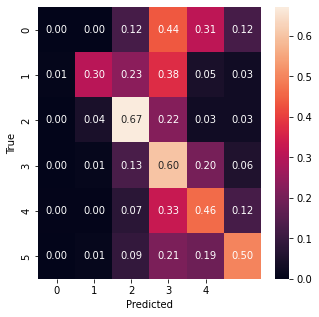

* Epoch 86 / 95


100%|██████████| 372/372 [02:06<00:00,  2.93it/s]


TRAIN - Time: 126.9s - Loss: 1.3742560789149298


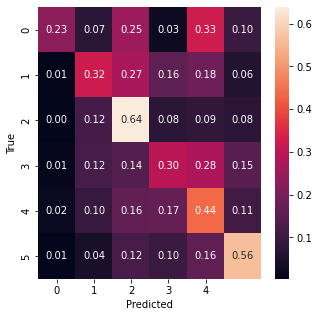

100%|██████████| 80/80 [00:14<00:00,  5.51it/s]


VALIDATION - Time: 14.5s - Loss: 1.3937148436903957


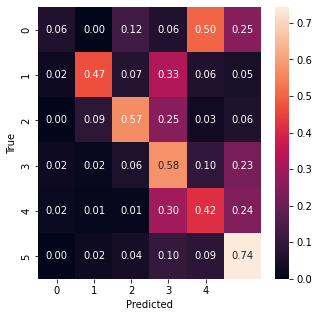

* Epoch 87 / 95


100%|██████████| 372/372 [02:06<00:00,  2.95it/s]


TRAIN - Time: 126.2s - Loss: 1.3510539023786456


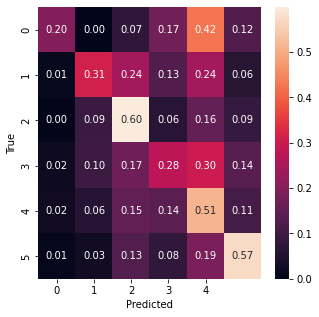

100%|██████████| 80/80 [00:14<00:00,  5.45it/s]


VALIDATION - Time: 14.7s - Loss: 1.354346808791161


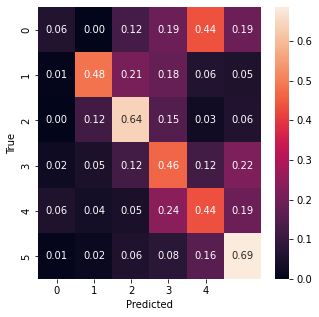

* Epoch 88 / 95


100%|██████████| 372/372 [02:08<00:00,  2.89it/s]


TRAIN - Time: 128.9s - Loss: 1.3728174116983198


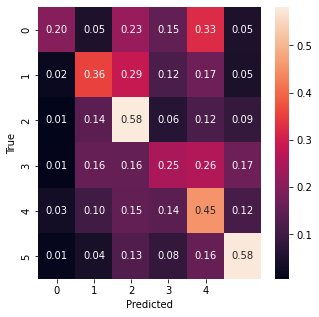

100%|██████████| 80/80 [00:14<00:00,  5.47it/s]


VALIDATION - Time: 14.6s - Loss: 1.3706736132502557


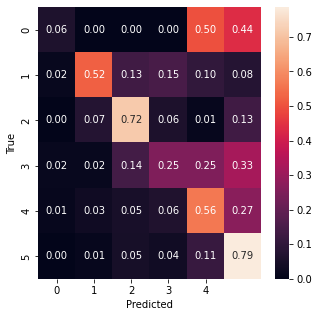

* Epoch 89 / 95


100%|██████████| 372/372 [02:05<00:00,  2.96it/s]


TRAIN - Time: 125.8s - Loss: 1.366618527520087


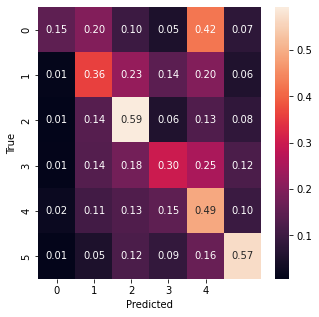

100%|██████████| 80/80 [00:14<00:00,  5.53it/s]


VALIDATION - Time: 14.5s - Loss: 1.690765767544508


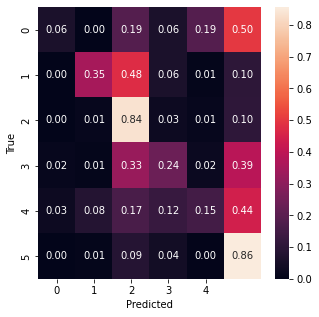

* Epoch 90 / 95


100%|██████████| 372/372 [02:06<00:00,  2.94it/s]


TRAIN - Time: 126.4s - Loss: 1.3791286054477898


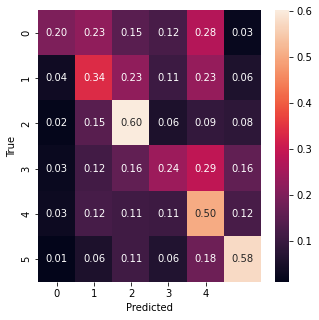

100%|██████████| 80/80 [00:14<00:00,  5.38it/s]


VALIDATION - Time: 14.9s - Loss: 1.3762997101992367


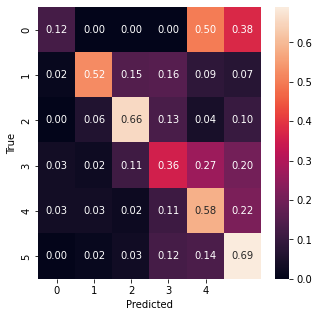

* Epoch 91 / 95


100%|██████████| 372/372 [02:05<00:00,  2.97it/s]


TRAIN - Time: 125.2s - Loss: 1.372414757006912


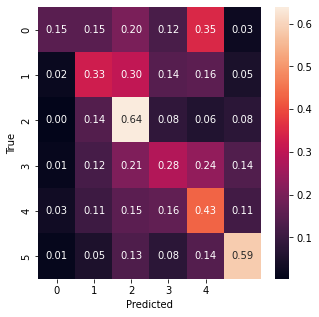

100%|██████████| 80/80 [00:14<00:00,  5.40it/s]


VALIDATION - Time: 14.8s - Loss: 1.3885617069900036


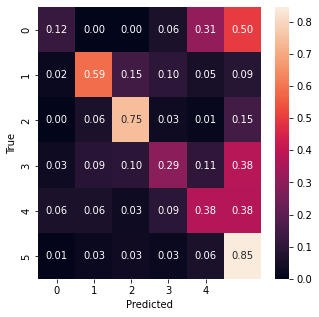

* Epoch 92 / 95


100%|██████████| 372/372 [02:07<00:00,  2.93it/s]


TRAIN - Time: 127.1s - Loss: 1.3503271091368865


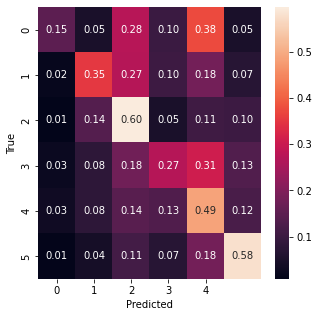

100%|██████████| 80/80 [00:14<00:00,  5.56it/s]


VALIDATION - Time: 14.4s - Loss: 1.4054962843656542


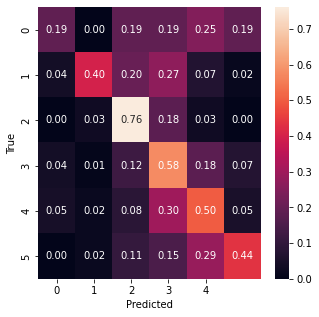

* Epoch 93 / 95


100%|██████████| 372/372 [02:07<00:00,  2.93it/s]


TRAIN - Time: 127.0s - Loss: 1.334288413005488


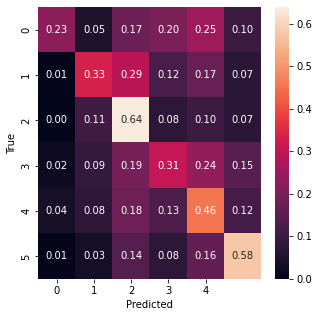

100%|██████████| 80/80 [00:14<00:00,  5.50it/s]


VALIDATION - Time: 14.6s - Loss: 1.3577535144984723


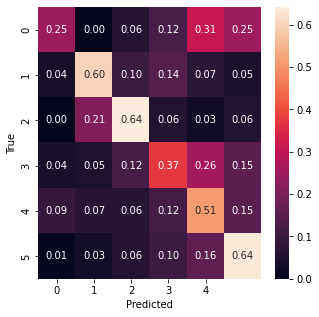

* Epoch 94 / 95


100%|██████████| 372/372 [02:06<00:00,  2.95it/s]


TRAIN - Time: 126.3s - Loss: 1.3328913995014726


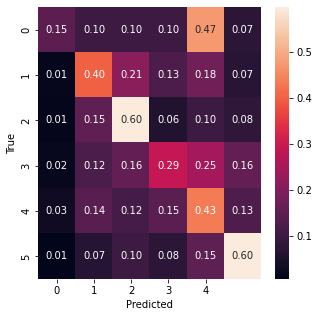

100%|██████████| 80/80 [00:14<00:00,  5.38it/s]


VALIDATION - Time: 14.9s - Loss: 1.3568089514970778


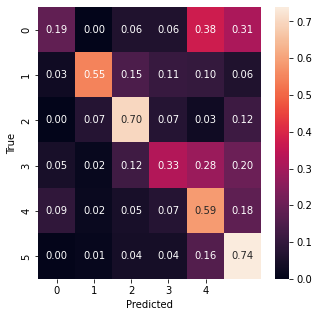

* Epoch 95 / 95


100%|██████████| 372/372 [02:11<00:00,  2.84it/s]


TRAIN - Time: 131.1s - Loss: 1.3533557605358855


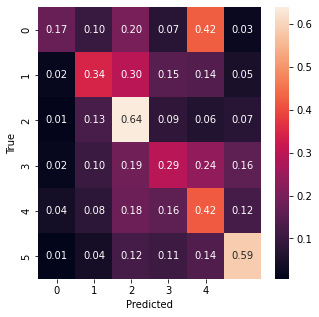

100%|██████████| 80/80 [00:15<00:00,  5.31it/s]


VALIDATION - Time: 15.1s - Loss: 1.344909262657166


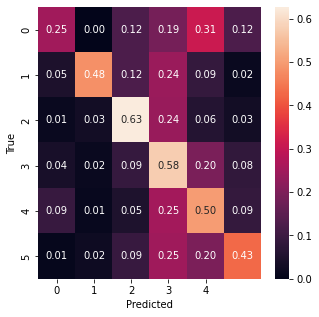

In [ ]:
################## DATA LOADING AND MODEL ##################

# Data albumentations
aug_1 = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(0.1),
    A.Rotate(180),
]

aug_2 = [
    A.Resize(img_size + img_size//20, img_size + img_size//20),
    A.RandomCrop(img_size, img_size),
    ToTensorV2()
]

train_transforms = A.Compose(aug_1 + aug_2)
transforms = A.Compose(aug_2)

# Data Splitting

print ("Loading dataset\n")
 
detection_dataset = pd.read_csv('/content/drive/Shareddrives/Projeto DACO/single label dataset/dataset_labels.csv')

label_encoder_1 = preprocessing.LabelEncoder()
detection_dataset ['presence'] = label_encoder_1.fit_transform(detection_dataset ['presence'])

label_encoder_2 = preprocessing.LabelEncoder()
detection_dataset ['type'] = label_encoder_2.fit_transform(detection_dataset ['type'])

# Labels map
print("Detection's Label Map")
print("Class 0 - ", label_encoder_1.inverse_transform([0]))
print("Class 1 - ", label_encoder_1.inverse_transform([1]))

print("\nClassification's Label Map")
print("Class 0 - ", label_encoder_2.inverse_transform([0]))
print("Class 1 - ", label_encoder_2.inverse_transform([1]))
print("Class 2 - ", label_encoder_2.inverse_transform([2]))
print("Class 3 - ", label_encoder_2.inverse_transform([3]))
print("Class 4 - ", label_encoder_2.inverse_transform([4]))
print("Class 5 - ", label_encoder_2.inverse_transform([5]))

d_train_set, d_val_set = train_test_split(detection_dataset, test_size=0.3, random_state=123)
d_val_set, d_test_set = train_test_split(d_val_set, test_size=0.5, random_state=123)


classification_dataset = detection_dataset
class_weights = class_weight.compute_class_weight(
              class_weight='balanced',
              classes=[0, 1, 2, 3, 4, 5], 
              y=classification_dataset['type'])

class_weights = torch.tensor(class_weights,dtype=torch.float).cuda()

c_train_set, c_val_set = d_train_set, d_val_set

c_train_set, c_val_set = c_train_set.reset_index(drop=True), c_val_set.reset_index(drop=True)

c_train_set = small_dataset(c_train_set, dataset_fold, train_transforms)
c_val_set = small_dataset(c_val_set, dataset_fold, transforms)

tr = DataLoader(c_train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val = DataLoader(c_val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print ("\nLoaded \n")

# Model

if (model_selected == 'VGG'):
  model = VGG16()

opt = optim.Adam(model.parameters(), lr = LEARNING_RATE)

loss_fc = nn.CrossEntropyLoss(weight=class_weights)

################## TRAINING ##################

print("\nTraining")

train_history = []
val_history = []
best_val_loss = np.inf

epoch_values = []

for epoch in range(EPOCHS):
      print(f'* Epoch {epoch+1} / {EPOCHS}')
      
      train_loss, tr_true_pred, tr_final_pred = epoch_iterations (tr, model, loss_fc, device, 'TRAIN', opt, True)
      evaluation_metrics(tr_true_pred, tr_final_pred)
      
      val_loss, val_true_pred, val_final_pred = epoch_iterations (val, model, loss_fc, device, 'VALIDATION', None,  False)
      evaluation_metrics(val_true_pred, val_final_pred)

      if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), model_selected + '_classification_best_model_baseline.pth')

      # save latest model
      torch.save(model.state_dict(), model_selected + '_classification_latest_model_baseline.pth')

      # save training history for plotting purposes
      train_history.append(train_loss)
      val_history.append(val_loss)
      epoch_values.append(epoch+1)
  


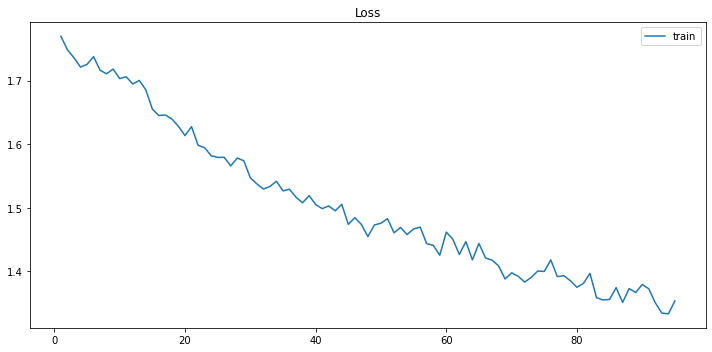

In [ ]:
loss_plot (epoch_values, train_history, val_history)

info= pd.DataFrame({"epochs": epoch_values, "train_loss":  train_history, "val_loss": val_history})

info.to_csv('/content/drive/Shareddrives/Projeto DACO/scripts code/stats - original/baseline_data.csv', index=False, header=True)